In [1]:
# First, we run SPIN's demo.py inference on an (cropped) image from 3dpw

img_path = 'examples/image_00502_crop.jpg'
#img_path = 'examples/image_00980.jpg'

pickle_path = 'data/3dpw/sequenceFiles/validation/courtyard_basketball_01.pkl'
#pickle_path = 'data/3dpw/sequenceFiles/validation/outdoors_parcours_01.pkl'

frame = 502

# From 3dpw readme.txt:


3DPW Dataset
============

The 3DPW dataset contains several motion sequences, which are organized into two folders: imageFiles and sequenceFiles.
The folder imageFiles contains the RGB-images for every sequence. 
The folder sequenceFiles provides synchronized motion data and SMPL model parameters in the form of .pkl-files. For each sequence, the .pkl-file contains a dictionary with the following fields:
- sequence: String containing the sequence name
- betas: SMPL shape parameters for each actor which has been used for tracking (List of 10x1 SMPL beta parameters)
- poses: SMPL body poses for each actor aligned with image data (List of Nx72 SMPL joint angles, N = #frames)
- trans: tranlations for each actor aligned with image data (List of Nx3 root translations)
- poses_60Hz: SMPL body poses for each actor at 60Hz (List of Nx72 SMPL joint angles, N = #frames)
- trans_60Hz: tranlations for each actor at 60Hz (List of Nx3 root translations)
- betas_clothed: SMPL shape parameters for each clothed actor (List of 10x1 SMPL beta parameters)
- v_template_clothed: 
- gender: actor genders (List of strings, either 'm' or 'f')
- texture_maps: texture maps for each actor
- poses2D: 2D joint detections in Coco-Format for each actor (only provided if at least 6 joints were detected correctly)
- jointPositions: 3D joint positions of each actor (List of Nx(24*3) XYZ coordinates of each SMPL joint)
- img_frame_ids: an index-array to down-sample 60 Hz 3D poses to corresponding image frame ids
- cam_poses: camera extrinsics for each image frame (Ix4x4 array, I frames times 4x4 homegenous rigid body motion matrices)
- campose_valid: a boolean index array indicating which camera pose has been aligned to the image
- cam_intrinsics: camera intrinsics (K = [f_x 0 c_x;0 f_y c_y; 0 0 1])

Each sequence has either one or two models, which corresponds to the list size of the model specific fields (e.g. betas, poses, trans, v_template, gender, texture_maps, jointPositions, poses2D). 
SMPL poses and translations are provided at 30 Hz. They are aligned to image dependent data (e.g. 2D poses, camera poses). In addition we provide 'poses_60Hz' and 'trans_60Hz' which corresponds to the recording frequency of 60Hz of the IMUs . You could use the 'img_frame_ids' to downsample and align 60Hz 3D and image dependent data, wich has been done to compute SMPL 'poses' and 'trans' variables. 
Please refer to the demo.py-file for loading a sequence, setup smpl-Models and camera, and to visualize an example frame.

In [2]:
# Secondly, we load the .pkl sequence file containing the ground-truth information from 3dpw

import pickle as pkl
import os

seq = pkl.load(open(pickle_path,'rb'),encoding='latin-1') # opening the sequence file, latin-1 encoding for making it compatible with python3

In [3]:
# Getting the sequence of poses for the same frame

import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json

from models import hmr, SMPL
from utils.imutils import crop
from utils.renderer_gt import Renderer
import config
import constants

seq_reshaped = np.reshape(seq['poses'][0][frame], (24, -1)) # reshaping the sequence file to make it inputtable on R.from_rotvec

from scipy.spatial.transform import Rotation as R

r = R.from_rotvec(seq_reshaped)
seq_matrix = r.as_dcm()

# Transforming the array of rotations into a tensor and adding one dimension, to make it compatible with the demo code

seq_tensor = torch.as_tensor(seq_matrix,dtype=torch.float, device='cuda').unsqueeze(0)
seq_tensor.size()

torch.Size([1, 24, 3, 3])

In [4]:
#seq['betas'] contains the beta parameters of the SMPL ground truth

gt_betas = torch.as_tensor(seq['betas'],dtype=torch.float, device='cuda')

In [5]:
# Running the demo code with the ground-truth pose from 3dpw

In [6]:
"""
Demo code

To run our method, you need a bounding box around the person. The person needs to be centered inside the bounding box and the bounding box should be relatively tight. You can either supply the bounding box directly or provide an [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) detection file. In the latter case we infer the bounding box from the detections.

In summary, we provide 3 different ways to use our demo code and models:
1. Provide only an input image (using ```--img```), in which case it is assumed that it is already cropped with the person centered in the image.
2. Provide an input image as before, together with the OpenPose detection .json (using ```--openpose```). Our code will use the detections to compute the bounding box and crop the image.
3. Provide an image and a bounding box (using ```--bbox```). The expected format for the json file can be seen in ```examples/im1010_bbox.json```.

Example with OpenPose detection .json
```
python3 demo.py --checkpoint=data/model_checkpoint.pt --img=examples/im1010.png --openpose=examples/im1010_openpose.json
```
Example with predefined Bounding Box
```
python3 demo.py --checkpoint=data/model_checkpoint.pt --img=examples/im1010.png --bbox=examples/im1010_bbox.json
```
Example with cropped and centered image
```
python3 demo.py --checkpoint=data/model_checkpoint.pt --img=examples/im1010.png
```

Running the previous command will save the results in ```examples/im1010_{shape,shape_side}.png```. The file ```im1010_shape.png``` shows the overlayed reconstruction of human shape. We also render a side view, saved in ```im1010_shape_side.png```.
"""

import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json

from models import hmr, SMPL
from utils.imutils import crop
from utils.renderer_gt import Renderer
import config
import constants

parser = argparse.ArgumentParser()
parser.add_argument('--checkpoint', required=True, help='Path to pretrained checkpoint')
parser.add_argument('--img', type=str, required=True, help='Path to input image')
parser.add_argument('--bbox', type=str, default=None, help='Path to .json file containing bounding box coordinates')
parser.add_argument('--openpose', type=str, default=None, help='Path to .json containing openpose detections')
parser.add_argument('--outfile', type=str, default=None, help='Filename of output images. If not set use input filename.')

def bbox_from_openpose(openpose_file, rescale=1.2, detection_thresh=0.2):
    """Get center and scale for bounding box from openpose detections."""
    with open(openpose_file, 'r') as f:
        keypoints = json.load(f)['people'][0]['pose_keypoints_2d']
    keypoints = np.reshape(np.array(keypoints), (-1,3))
    valid = keypoints[:,-1] > detection_thresh
    valid_keypoints = keypoints[valid][:,:-1]
    center = valid_keypoints.mean(axis=0)
    bbox_size = (valid_keypoints.max(axis=0) - valid_keypoints.min(axis=0)).max()
    # adjust bounding box tightness
    scale = bbox_size / 200.0
    scale *= rescale
    return center, scale

def bbox_from_json(bbox_file):
    """Get center and scale of bounding box from bounding box annotations.
    The expected format is [top_left(x), top_left(y), width, height].
    """
    with open(bbox_file, 'r') as f:
        bbox = np.array(json.load(f)['bbox']).astype(np.float32)
    ul_corner = bbox[:2]
    center = ul_corner + 0.5 * bbox[2:]
    width = max(bbox[2], bbox[3])
    scale = width / 200.0
    # make sure the bounding box is rectangular
    return center, scale

def process_image(img_file, bbox_file, openpose_file, input_res=224):
    """Read image, do preprocessing and possibly crop it according to the bounding box.
    If there are bounding box annotations, use them to crop the image.
    If no bounding box is specified but openpose detections are available, use them to get the bounding box.
    """
    normalize_img = Normalize(mean=constants.IMG_NORM_MEAN, std=constants.IMG_NORM_STD)
    img = cv2.imread(img_file)[:,:,::-1].copy() # PyTorch does not support negative stride at the moment
    if bbox_file is None and openpose_file is None:
        # Assume that the person is centerered in the image
        height = img.shape[0]
        width = img.shape[1]
        center = np.array([width // 2, height // 2])
        scale = max(height, width) / 200
    else:
        if bbox_file is not None:
            center, scale = bbox_from_json(bbox_file)
        elif openpose_file is not None:
            center, scale = bbox_from_openpose(openpose_file)
    img = crop(img, center, scale, (input_res, input_res))
    img = img.astype(np.float32) / 255.
    img = torch.from_numpy(img).permute(2,0,1)
    norm_img = normalize_img(img.clone())[None]
    return img, norm_img

if __name__ == '__main__':
    
    #args = parser.parse_args()
    #Here we insert our own bootlegged arguments list
    #
    args = parser.parse_args(['--checkpoint=data/model_checkpoint.pt','--img='+img_path])
    #
    #
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    # Load pretrained model
    model = hmr(config.SMPL_MEAN_PARAMS).to(device)
    checkpoint = torch.load(args.checkpoint)
    model.load_state_dict(checkpoint['model'], strict=False)

    # Load SMPL model
    smpl = SMPL(config.SMPL_MODEL_DIR,
                batch_size=1,
                create_transl=False).to(device)
    model.eval()

    # Setup renderer for visualization
    renderer = Renderer(focal_length=constants.FOCAL_LENGTH, img_res=constants.IMG_RES, faces=smpl.faces)


    # Preprocess input image and generate predictions
    img, norm_img = process_image(args.img, args.bbox, args.openpose, input_res=constants.IMG_RES)
    with torch.no_grad():
        pred_rotmat, pred_betas, pred_camera = model(norm_img.to(device))
        
        # We are bootlegging our ground_truth parameters here
        pred_output = smpl(betas=gt_betas, body_pose=seq_tensor[:,1:], global_orient=seq_tensor[:,0].unsqueeze(1), pose2rot=False)
        #
        
        pred_vertices = pred_output.vertices
        
    # Calculate camera parameters for rendering
    camera_translation = torch.stack([pred_camera[:,1], pred_camera[:,2], 2*constants.FOCAL_LENGTH/(constants.IMG_RES * pred_camera[:,0] +1e-9)],dim=-1)
    camera_translation = camera_translation[0].cpu().numpy()
    pred_vertices = pred_vertices[0].cpu().numpy()
    img = img.permute(1,2,0).cpu().numpy()

    
    # Render parametric shape
    img_shape = renderer(pred_vertices, camera_translation, img, pickle_path, frame)
    
    # Render side views
    aroundy = cv2.Rodrigues(np.array([0, np.radians(90.), 0]))[0]
    center = pred_vertices.mean(axis=0)
    rot_vertices = np.dot((pred_vertices - center), aroundy) + center
    
    # Render non-parametric shape
    img_shape_side = renderer(rot_vertices, camera_translation, np.ones_like(img), pickle_path, frame)

    outfile = args.img.split('.')[0] if args.outfile is None else args.outfile
    
    # Here we add _gt_ to differentiate the output

    # Save reconstructions
    cv2.imwrite(outfile + '_gt_shape.png', 255 * img_shape[:,:,::-1])
    cv2.imwrite(outfile + '_gt_shape_side.png', 255 * img_shape_side[:,:,::-1])

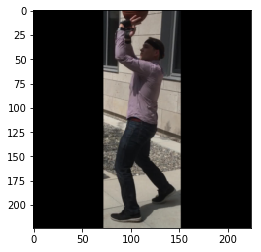

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

output_image = plt.imread(img_path[:-4]+'_gt_shape.png')
plt.imshow(output_image)

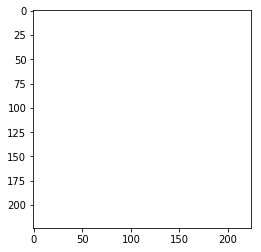

In [8]:
output_image_side = plt.imread(img_path[:-4]+'_gt_shape_side.png')
plt.imshow(output_image_side)

In [9]:
seq = pkl.load(open(pickle_path,'rb'),encoding='latin-1')

In [10]:
seq['cam_poses'][frame][:3, 3]

array([-4.51536851, -1.09855333,  1.71583693])

In [11]:
camera_translation

array([-6.7126518e-03,  2.4322587e-01,  4.5735645e+01], dtype=float32)

In [12]:
seq['cam_poses'][frame]

array([[ 0.87993836,  0.01627723,  0.47480895, -4.51536851],
       [-0.12350747, -0.95721291,  0.26170471, -1.09855333],
       [ 0.45875308, -0.28892647, -0.84027799,  1.71583693],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [13]:
camera_translation = torch.stack([pred_camera[:,1], pred_camera[:,2], 2*constants.FOCAL_LENGTH/(constants.IMG_RES * pred_camera[:,0] +1e-9)],dim=-1)

In [14]:
pred_camera

tensor([[ 0.9761, -0.0067,  0.2432]], device='cuda:0')

In [15]:
camera_translation

tensor([[-6.7127e-03,  2.4323e-01,  4.5736e+01]], device='cuda:0')

In [16]:
camera_translation = camera_translation[0].cpu().numpy()

In [17]:
camera_translation

array([-6.7126518e-03,  2.4322587e-01,  4.5735645e+01], dtype=float32)

In [18]:
camera_translation[0] *= -1.

In [19]:
camera_translation

array([6.7126518e-03, 2.4322587e-01, 4.5735645e+01], dtype=float32)

In [20]:
2*constants.FOCAL_LENGTH/(constants.IMG_RES * seq['cam_poses'][frame][2,3] +1e-9)/4.82

5.397950925531867

In [21]:
1080/224

4.821428571428571